In [18]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


import numpy as np
import matplotlib.pyplot as plt
import scipy

#from google.colab import runtime


In [19]:
#Hyperparameters
lr = 0.00001
momentum = 0 #default = 0
weight_decay = 0.05 #default = 0
dampening = 0 #default = 0

#Other
batch_size = 16
epochs = 200

epochs_between_hist = 1

PATH = './CNNv3_5clyrs33_ep200_bn16.pth'

In [20]:
transforms = {
    'train':
    #Composing several transforms together
    transforms.Compose(
        [
            transforms.RandomRotation(degrees=45),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(),
            transforms.GaussianBlur(1),
            transforms.RandomAdjustSharpness(1),
            transforms.RandomPerspective(),
            transforms.ToTensor(), #To tensor object
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Mean = 0.5, std = 0.5
            transforms.Resize((256,256)) #Speeds up model without losing too much information
        ]),

    'trainOld':
    transforms.Compose(
        [
            transforms.TrivialAugmentWide(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256)),
        ]
    ),

    'val':
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256))
        ]),

    'test':
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256))
        ])
}

In [21]:
train_data = datasets.Flowers102(root='./data', split='train', transform=transforms['train'], download=True)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

In [22]:
val_data = datasets.Flowers102(root='./data', split='val', transform=transforms['val'], download=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [23]:
test_data = datasets.Flowers102(root='./data', split='test', transform=transforms['test'], download=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
#dataloaders = {
#    'train': train_dataloader,
#    'val': val_dataloader
#}

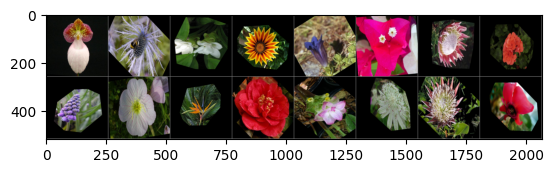

In [24]:
# Show the images in the batch to see what the transforms are doing to them
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_dataloader)
for i in range(1):
  images, lbls = next(dataiter)
  imshow(torchvision.utils.make_grid(images))

In [25]:
#Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [26]:
#Architecture inspired by https://poloclub.github.io/cnn-explainer/#article-input
#and PyTorch for Deep Learning & Machine Learning – Full Course by freeCodeCamp.org https://www.youtube.com/watch?v=V_xro1bcAuA
class CNNv3(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    #Block is comprised of multiple layers
    self.convLayer1 = self.ConvLayers(input_shape, hidden_units)
    self.convLayer2 = self.ConvLayers(hidden_units, hidden_units)
    self.convLayer3 = self.ConvLayers(hidden_units, hidden_units)
    self.convLayer4 = self.ConvLayers(hidden_units, hidden_units)
    self.convLayer5 = self.ConvLayers(hidden_units, hidden_units)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*8*8,
                  out_features=1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(in_features=1024,
                  out_features=512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(in_features=512,
                  out_features=output_shape)

    )

  def ConvLayers(self, input_shape, hidden_units):
    return nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

  def forward(self, x):
    x = self.convLayer1(x)
    #print(x.shape)
    x = self.convLayer2(x)
    #print(x.shape)
    x = self.convLayer3(x)
    #print(x.shape)
    x = self.convLayer4(x)
    #print(x.shape)
    x = self.convLayer5(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

In [27]:
model = CNNv3(input_shape=3,
              hidden_units=256,
              output_shape=102).to(device)
print(model)

CNNv3(
  (convLayer1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer3): Sequential(
   

In [28]:
#Loss function and optimiser
loss_fn = nn.CrossEntropyLoss()
#optimiser = torch.optim.SGD(model.parameters(),
#                            lr=lr,
#                            momentum=momentum,
#                            weight_decay=weight_decay,
#                            dampening=dampening)
optimiser = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)


In [29]:
#Train the model using the training data
def train(dataloader, model, loss_fn, optimiser):
  size = len(dataloader.dataset)
  batches = len(dataloader)
  model.train()
  running_loss, running_corrects = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    running_loss += loss.item()
    running_corrects += torch.count_nonzero(pred.argmax(1)==y).item()

    # Backpropagation
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()

  ave_loss = running_loss/batches
  corrects = running_corrects/size

  print(f"Train Error: \nAccuracy: {(100*corrects):.2f}%, Avg loss: {ave_loss:.6f} \n")
  return ave_loss, corrects


In [30]:
#Validate the models progress using the validation data
def valTest(dataloader, model, loss_fn, split):
  size = len(dataloader.dataset)
  batches = len(dataloader)
  model.eval()
  running_loss, running_corrects = 0, 0

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss = loss_fn(pred,y)

      running_loss += loss.item()
      running_corrects += torch.count_nonzero(pred.argmax(1)==y).item()

  ave_loss = running_loss/batches
  corrects = running_corrects/size

  print(f"{split} Error: \n Accuracy: {(100*corrects):.2f}%, Avg loss: {ave_loss:.6f} \n")

  return ave_loss, corrects


In [31]:
def pltHist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(121)
  plt.plot(hist['epochs'], hist['train_loss'], 'o-', hist['epochs'], hist['val_loss'], 'o-')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train', 'Val'])
  plt.title('Train vs Validation loss')

  plt.subplot(122)
  plt.plot(hist['epochs'], hist['train_accuracy'], 'o-', hist['epochs'], hist['val_accuracy'], 'o-')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Val'])
  plt.title('Train vs Validation Accuracy')

In [32]:
def trainValLoop(model, loss_fn, optimiser, epochs):
  train_loss_hist = []
  train_acc_hist = []
  val_loss_hist = []
  val_acc_hist = []
  epochs_hist = []

  train_loss_ave = 0
  train_acc_ave = 0
  val_loss_ave = 0
  val_acc_ave = 0

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs} -------------------------------")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimiser)
    val_loss, val_acc = valTest(val_dataloader, model, loss_fn, 'Validate')

    train_loss_ave += train_loss
    train_acc_ave += train_acc
    val_loss_ave += val_loss
    val_acc_ave += val_acc

    if (epoch + 1) % epochs_between_hist == 0:
      train_loss_hist.append(train_loss_ave / epochs_between_hist)
      train_acc_hist.append(train_acc_ave / epochs_between_hist)
      val_loss_hist.append(val_loss_ave / epochs_between_hist)
      val_acc_hist.append(val_acc_ave / epochs_between_hist)
      epochs_hist.append(epoch + 1)

      train_loss_ave = 0
      train_acc_ave = 0
      val_loss_ave = 0
      val_acc_ave = 0

  hist = {'train_loss': train_loss_hist, 'train_accuracy': train_acc_hist,
          'val_loss': val_loss_hist, 'val_accuracy': val_acc_hist, 'epochs': epochs_hist}
  pltHist(hist)
  valTest(test_dataloader, model, loss_fn, 'Test')

  return hist


In [22]:
hist = trainValLoop(model, loss_fn, optimiser, epochs)

Epoch 1/500 -------------------------------
Train Error: 
Accuracy: 1.37%, Avg loss: 4.683878 



KeyboardInterrupt: 

In [38]:
#Load and test the model
#model = model.load_state_dict(torch.load('/content/CNNv3_bnFul_ep200_bs16.pth'))

#valTest(test_dataloader, model, loss_fn, 'Test')

RuntimeError: PytorchStreamReader failed reading zip archive: invalid header or archive is corrupted

In [ ]:
#Save model
torch.save(model.state_dict(), PATH)

In [ ]:
print("#Hyperparameters")
print(f"lr = {lr:.5f}")
print(f"momentum = {momentum}")
print(f"weight_decay = {weight_decay}")
print(f"dampening = {dampening}")
print()
print("#Other")
print(f"batch_size = {batch_size}")
print(f"epochs = {epochs}")

In [ ]:
print(hist)

In [ ]:
#Stops Google stealing my credits
#runtime.unassign()

In [41]:
#histVik =

#train_loss_hist = []
#train_acc_hist = []
#val_loss_hist = []
#val_acc_hist = []
#epochs_hist = []

#prevI = 0
#for i in histVik['train_loss']:
#  train_loss_hist.append(i - prevI)
#  prevI = i

#prevI = 0
#for i in histVik['train_accuracy']:
#  train_acc_hist.append(i - prevI)
#  prevI = i

#prevI = 0
#for i in histVik['val_loss']:
#  val_loss_hist.append(i - prevI)
#  prevI = i

#prevI = 0
#for i in histVik['val_accuracy']:
#  val_acc_hist.append(i - prevI)
#  prevI = i

#for i in histVik['epochs']:
#  epochs_hist.append(i+1)

#hist = {'train_loss': train_loss_hist, 'train_accuracy': train_acc_hist,
#        'val_loss': val_loss_hist, 'val_accuracy': val_acc_hist, 'epochs': epochs_hist}

#pltHist(hist)